In [22]:
#Imports
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss
import warnings
warnings.filterwarnings('ignore')

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

## setting random state for reproducibility
SEED = 42
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

!pip install pandas
!pip install sklearn

In [34]:
## Importing Custom Functions
import sys,os
sys.path.append(os.path.abspath("../"))
%load_ext autoreload
%autoreload 2
from Code import Data_Enrichment as de

### **Load Data**

In [2]:
#Load Data
file = 'Data/sales_predictions_2023.csv'

df = pd.read_csv(file)


### **Inspect Data**

#### **Head()**

In [3]:
#Head()
df.head(2)

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility    Item_Type  \
0           FDA15         9.30          Low Fat         0.016047        Dairy   
1           DRC01         5.92          Regular         0.019278  Soft Drinks   

   Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0  249.8092            OUT049                       1999      Medium   
1   48.2692            OUT018                       2009      Medium   

  Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  
0               Tier 1  Supermarket Type1          3735.1380  
1               Tier 3  Supermarket Type2           443.4228

#### **shape()**

In [4]:
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')

There are 8523 rows, and 12 columns.


#### **dtypes**

In [5]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

#### **Info()**

In [6]:
#Info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


#### **describe()**

In [7]:
#Descriptive statistics for numeric columns
df.describe(include='number')

Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800

In [8]:
#Descriptive statistics for categoric columns
df.describe(include='object')

Item_Identifier Item_Fat_Content              Item_Type  \
count             8523             8523                   8523   
unique            1559                5                     16   
top              FDW13          Low Fat  Fruits and Vegetables   
freq                10             5089                   1232   

       Outlet_Identifier Outlet_Size Outlet_Location_Type        Outlet_Type  
count               8523        6113                 8523               8523  
unique                10           3                    3                  4  
top               OUT027      Medium               Tier 3  Supermarket Type1  
freq                 935        2793                 3350               5577

## **Clean Data**

#### **Dropping/Replacing Columns**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


#### **Duplicated Data**


In [10]:
dup_rows = df.duplicated().sum()
print(f'There are {dup_rows} duplicate rows.')

There are 0 duplicate rows.


#### **Unique Values**

In [11]:
df.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [12]:
#Unique Value percentage
unique_percentage = df.nunique()/len(df) * 100
unique_percentage

Item_Identifier              18.291681
Item_Weight                   4.869178
Item_Fat_Content              0.058665
Item_Visibility              92.455708
Item_Type                     0.187727
Item_MRP                     69.670304
Outlet_Identifier             0.117330
Outlet_Establishment_Year     0.105597
Outlet_Size                   0.035199
Outlet_Location_Type          0.035199
Outlet_Type                   0.046932
Item_Outlet_Sales            40.983222
dtype: float64

In [13]:
# save list of categorical column name.
categorical_col = df.select_dtypes('object').columns
categorical_col

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [14]:
# Check for nunique for categorical columns
for col in categorical_col:
  print(f'Value Counts for {col}')
  print(df[col].value_counts())
  print('\n')

Value Counts for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value Counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value Counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value Counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930


#### **Data Consistency**

#####  **Data Consistency- Categorical Columns**




In [15]:
# Item_Fat_Content- fix the values
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(['low fat' , 'LF'], 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg' , 'Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

<Axes: >

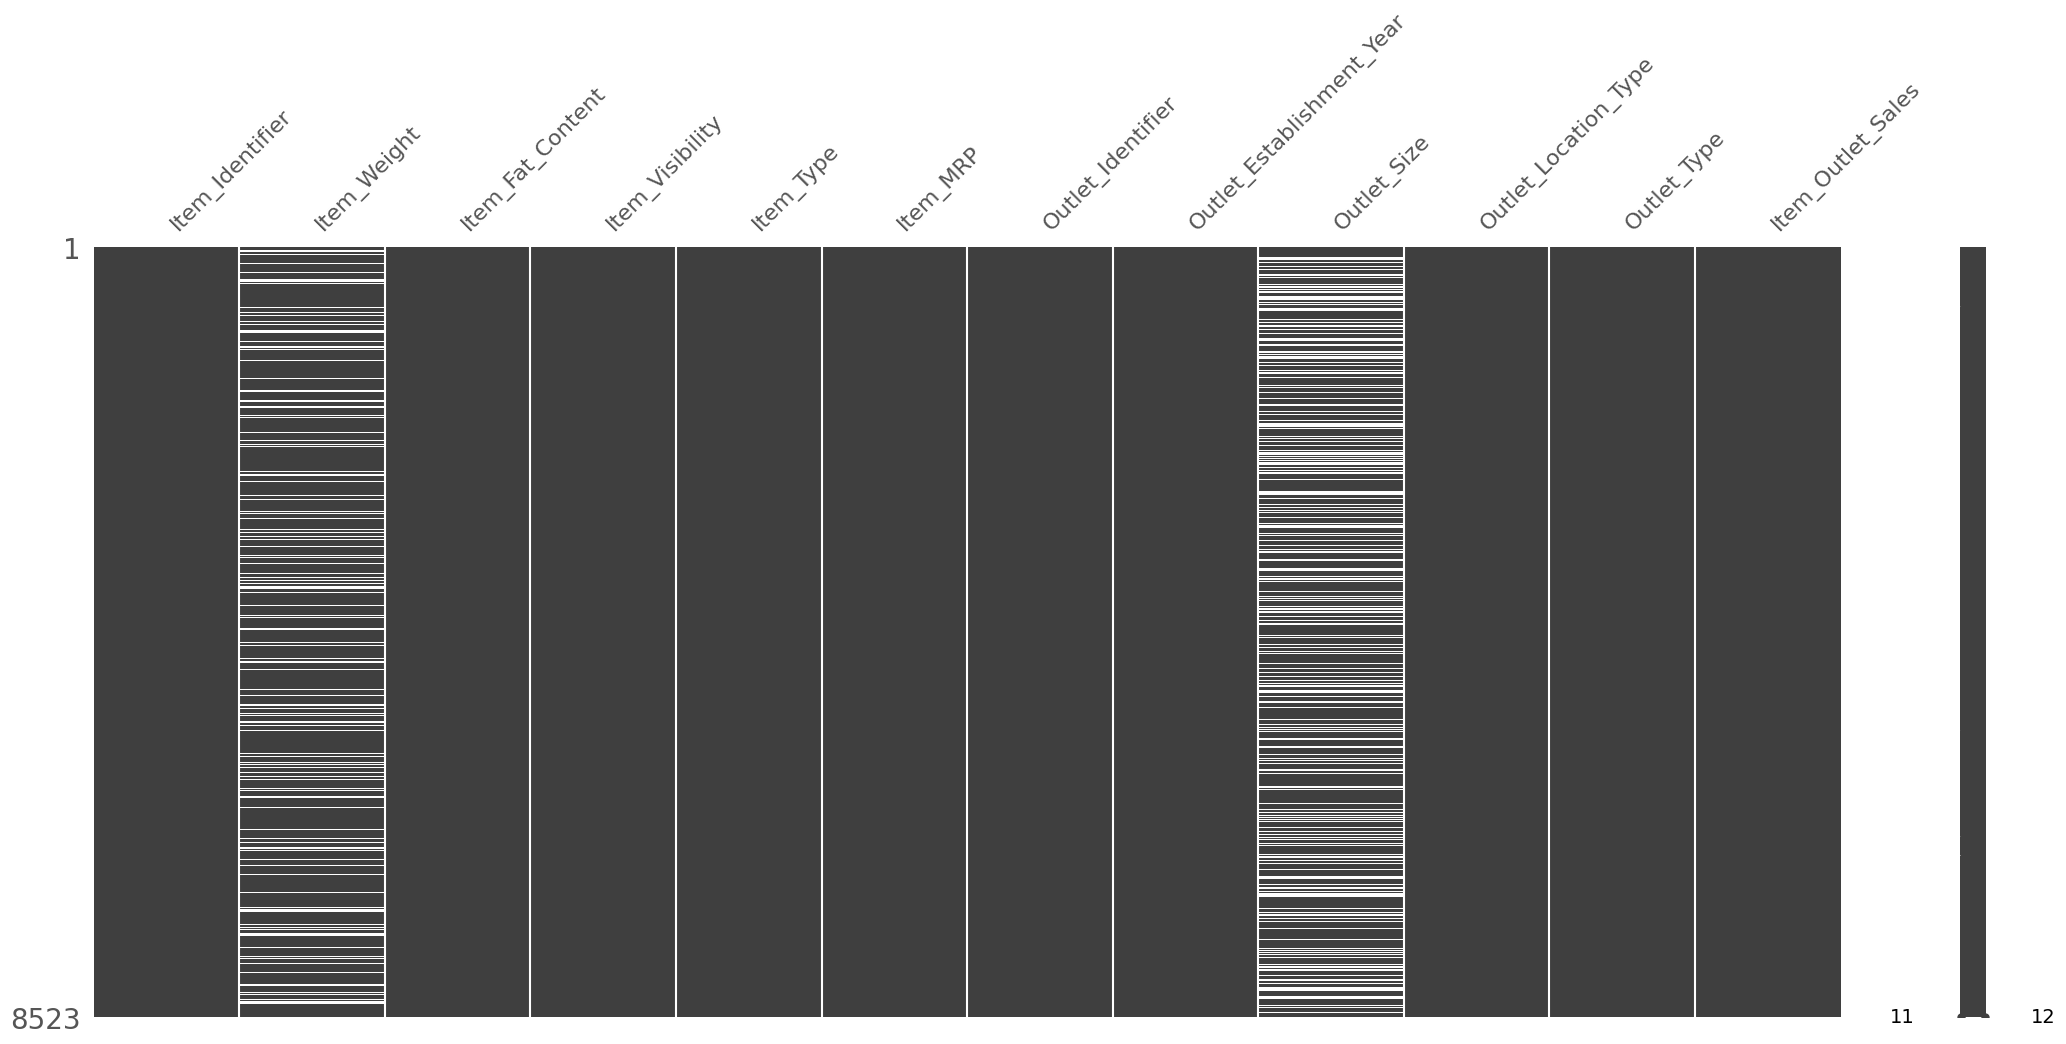

In [16]:
miss.matrix(df)

**Cardinality**
- The column "ITem_Identifier" has 1559 unique values.
- High cardinality will create a very sparse dataset when it is One Hot Encoded, which can negatively impact the models' metrics, and greatly increase processing times.
- It will be better to drop this column.

In [17]:
#Drop 'Item_Identifier'
df.drop(columns = 'Item_Identifier', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                6113 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 732.6+ KB


In [18]:
# clean extra spaces
df.columns = df.columns.str.strip()
df.head(2)

Item_Weight Item_Fat_Content  Item_Visibility    Item_Type  Item_MRP  \
0         9.30          Low Fat         0.016047        Dairy  249.8092   
1         5.92          Regular         0.019278  Soft Drinks   48.2692   

  Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0            OUT049                       1999      Medium   
1            OUT018                       2009      Medium   

  Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  
0               Tier 1  Supermarket Type1          3735.1380  
1               Tier 3  Supermarket Type2           443.4228

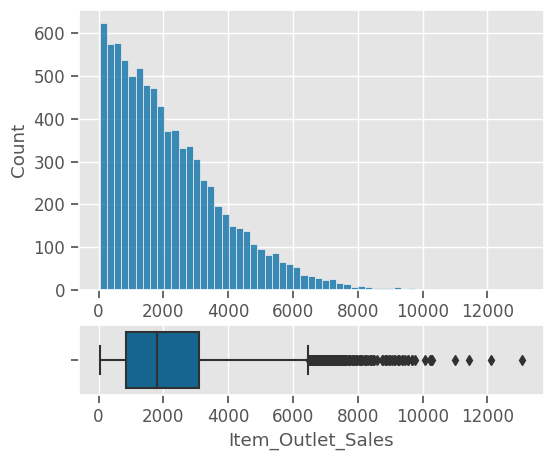

In [19]:
target = 'Item_Outlet_Sales'

grid_spec = {'height_ratios':[0.8,0.2]}
fig, axes = plt.subplots(nrows=2, figsize=(6,5), gridspec_kw=grid_spec)

sns.histplot(data=df, x=target,ax=axes[0])
sns.boxplot(data=df, x=target, ax=axes[1]);

## **Preprocessing (with Sklearn v1.1+)**

In [20]:
# Run the following command on your local computer to check the version of sklearn
import sklearn
!python --version
print(f"sklearn version: {sklearn.__version__}")

Python 3.9.15
sklearn version: 1.2.2


### Train-Test-Split

In [23]:
#Train Test Split
## Make x and y variables
target = "Item_Outlet_Sales"
drop_feats = []

y = df[target].copy()
X = df.drop(columns=[target, *drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head(3)

Item_Weight Item_Fat_Content  Item_Visibility    Item_Type  Item_MRP  \
4776        16.35          Low Fat         0.029565    Household  256.4646   
7510        15.25          Regular         0.000000  Snack Foods  179.7660   
5828        12.35          Regular         0.158716         Meat  157.2946   

     Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
4776            OUT018                       2009      Medium   
7510            OUT018                       2009      Medium   
5828            OUT049                       1999      Medium   

     Outlet_Location_Type        Outlet_Type  
4776               Tier 3  Supermarket Type2  
7510               Tier 3  Supermarket Type2  
5828               Tier 1  Supermarket Type1

### Pipelines

In [24]:
# Make numeric preprocessing pipeline
num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer())])

In [25]:
# Make categorical preprocessing pipeline
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
cat_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

### Column Transformer

In [26]:
# make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14efb8a90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14efab4f0>)])

In [27]:
# Make X_train_df and X_test_df, dataframe verisons of processed X_train/X_test.

preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

pipeline-1__Item_Weight  pipeline-1__Item_Visibility  \
4776                   16.350                     0.029565   
7510                   15.250                     0.000000   
5828                   12.350                     0.158716   
5327                    7.975                     0.014628   
4810                   19.350                     0.016645   
...                       ...                          ...   
5734                    9.395                     0.286345   
5191                   15.600                     0.117575   
5390                   17.600                     0.018944   
860                    20.350                     0.054363   
7270                   16.350                     0.016993   

      pipeline-1__Item_MRP  pipeline-1__Outlet_Establishment_Year  \
4776              256.4646                                 2009.0   
7510              179.7660                                 2009.0   
5828              157.2946                                 1999.0   
5327               82.3250                                 2004.0   
4810              120.9098                                 2002.0   
...                    ...                                    ...   
5734              139.1838                                 1998.0   
5191               75.6670                                 2007.0   
5390              237.3590                                 2002.0   
860               117.9466                                 2007.0   
7270               95.7410                                 1997.0   

      pipeline-2__Item_Fat_Content_Low Fat  \
4776                                   1.0   
7510                                   0.0   
5828                                   0.0   
5327                                   1.0   
4810                                   1.0   
...                                    ...   
5734                                   0.0   
5191                                   1.0   
5390                                   1.0   
860                                    1.0   
7270                                   1.0   

      pipeline-2__Item_Fat_Content_Regular  \
4776                                   0.0   
7510                                   1.0   
5828                                   1.0   
5327                                   0.0   
4810                                   0.0   
...                                    ...   
5734                                   1.0   
5191                                   0.0   
5390                                   0.0   
860                                    0.0   
7270                                   0.0   

      pipeline-2__Item_Type_Baking Goods  pipeline-2__Item_Type_Breads  \
4776                                 0.0                           0.0   
7510                                 0.0                           0.0   
5828                                 0.0                           0.0   
5327                                 1.0                           0.0   
4810                                 0.0                           0.0   
...                                  ...                           ...   
5734                                 0.0                           0.0   
5191                                 0.0                           0.0   
5390                                 0.0                           0.0   
860                                  0.0                           0.0   
7270                                 0.0                           0.0   

      pipeline-2__Item_Type_Breakfast  pipeline-2__Item_Type_Canned  ...  \
4776                              0.0                           0.0  ...   
7510                              0.0                           0.0  ...   
5828                              0.0                           0.0  ...   
5327                              0.0                           0.0  ...   
4810                              0.0                    

In [28]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 43 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   pipeline-1__Item_Weight                      6392 non-null   float64
 1   pipeline-1__Item_Visibility                  6392 non-null   float64
 2   pipeline-1__Item_MRP                         6392 non-null   float64
 3   pipeline-1__Outlet_Establishment_Year        6392 non-null   float64
 4   pipeline-2__Item_Fat_Content_Low Fat         6392 non-null   float64
 5   pipeline-2__Item_Fat_Content_Regular         6392 non-null   float64
 6   pipeline-2__Item_Type_Baking Goods           6392 non-null   float64
 7   pipeline-2__Item_Type_Breads                 6392 non-null   float64
 8   pipeline-2__Item_Type_Breakfast              6392 non-null   float64
 9   pipeline-2__Item_Type_Canned                 6392 non-null   float64
 1

In [29]:
# make the preprocessing column transformer WITH CORRECT ARGS!
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
4776       16.350         0.029565  256.4646                     2009.0   
7510       15.250         0.000000  179.7660                     2009.0   
5828       12.350         0.158716  157.2946                     1999.0   
5327        7.975         0.014628   82.3250                     2004.0   
4810       19.350         0.016645  120.9098                     2002.0   
...           ...              ...       ...                        ...   
5734        9.395         0.286345  139.1838                     1998.0   
5191       15.600         0.117575   75.6670                     2007.0   
5390       17.600         0.018944  237.3590                     2002.0   
860        20.350         0.054363  117.9466                     2007.0   
7270       16.350         0.016993   95.7410                     1997.0   

      Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
4776                       1.0                       0.0   
7510                       0.0                       1.0   
5828                       0.0                       1.0   
5327                       1.0                       0.0   
4810                       1.0                       0.0   
...                        ...                       ...   
5734                       0.0                       1.0   
5191                       1.0                       0.0   
5390                       1.0                       0.0   
860                        1.0                       0.0   
7270                       1.0                       0.0   

      Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
4776                     0.0               0.0                  0.0   
7510                     0.0               0.0                  0.0   
5828                     0.0               0.0                  0.0   
5327                     1.0               0.0                  0.0   
4810                     0.0               0.0                  0.0   
...                      ...               ...                  ...   
5734                     0.0               0.0                  0.0   
5191                     0.0               0.0                  0.0   
5390                     0.0               0.0                  0.0   
860                      0.0               0.0                  0.0   
7270                     0.0               0.0                  0.0   

      Item_Type_Canned  ...  Outlet_Size_MISSING  Outlet_Size_Medium  \
4776               0.0  ...                  0.0                 1.0   
7510               0.0  ...                  0.0                 1.0   
5828               0.0  ...                  0.0                 1.0   
5327               0.0  ...                  0.0                 0.0   
4810               0.0  ...                  1.0                 0.0   
...                ...  ...                  ...                 ...   
5734               0.0  ...                  1.0                 0.0   
5191               0.0  ...                  1.0                 0.0   
5390               0.0  ...                  1.0                 0.0   
860                0.0  ...                  1.0                 0.0   
7270               0.0  ...                  0.0                 0.0   

      Outlet_Size_Small  Outlet_Location_Type_Tier 1  \
4776                0.0                          0.0   
7510                0.0                          0.0   
5828                0.0                          1.0   
5327                1.0                          0.0   
4810                0.0                          0.0   
...                 ...                          ...   
5734                0.0                          0.0   
5191                0.0                          0.0   
5390                0.0                          0.0   
860                 0.0                          0.0   
7270                1.0                          1

# **Modeling - Linear Regression**

In [31]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    # Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    # Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")


## Model 1: Baseline LinReg



In [32]:
from sklearn.linear_model import LinearRegression
lin_reg= LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

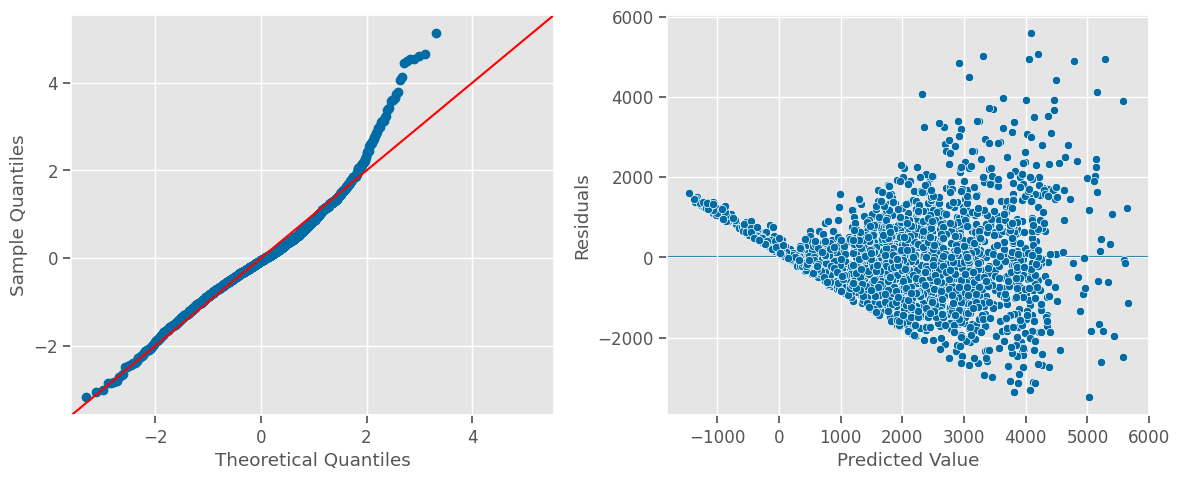

In [35]:
de.plot_residuals(lin_reg, X_test_df,y_test)

### Extracting and Visualizing Coefficients

#### def `get_coefficients`

In [36]:
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

In [38]:
coeffs = get_coefficients(lin_reg)
coeffs.sort_values()

Outlet_Type_Grocery Store           -895.874464
Outlet_Identifier_OUT019            -469.809463
Outlet_Identifier_OUT010            -426.065001
Item_Visibility                     -423.390180
Outlet_Location_Type_Tier 1         -252.738750
Outlet_Size_MISSING                 -247.698153
Item_Type_Dairy                     -124.947555
Outlet_Size_Small                   -106.344253
Outlet_Identifier_OUT049             -84.311094
Outlet_Type_Supermarket Type2        -82.517344
Outlet_Identifier_OUT018             -82.517344
Outlet_Size_High                     -67.363912
Outlet_Identifier_OUT013             -67.363912
Item_Type_Soft Drinks                -58.098276
Item_Type_Breads                     -47.260859
Item_Type_Others                     -45.426266
Item_Type_Snack Foods                -40.544933
Item_Fat_Content_Low Fat             -31.312617
Item_Type_Meat                       -30.477427
Item_Type_Frozen Foods               -20.383167
Outlet_Identifier_OUT045             -19

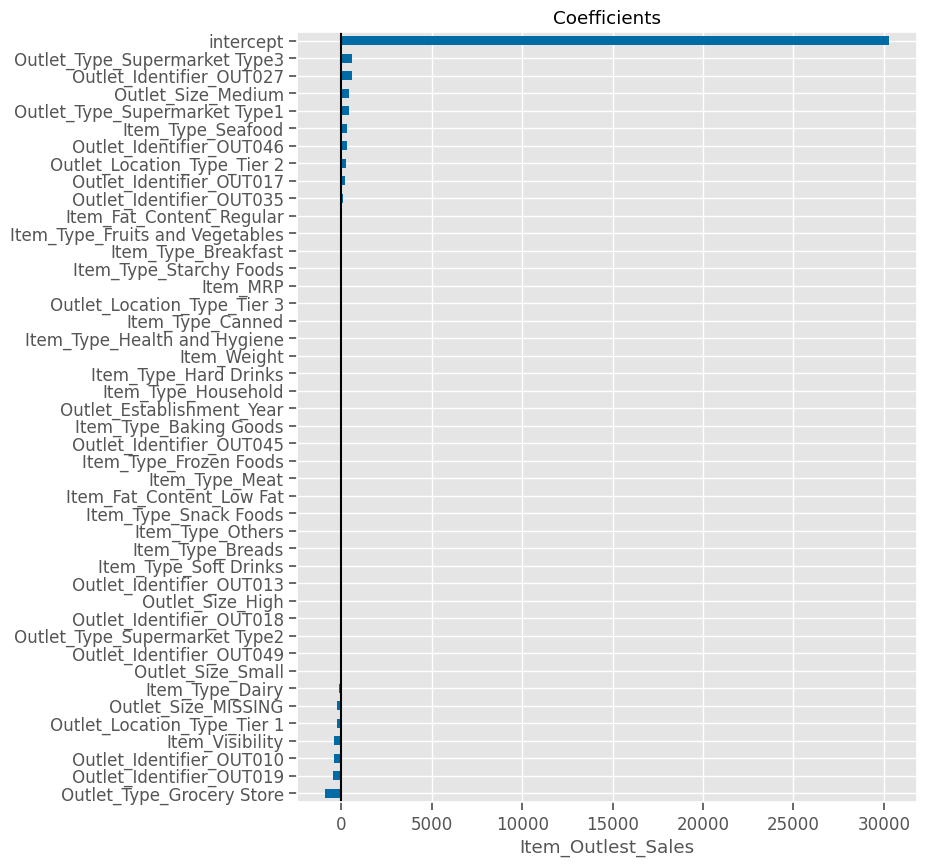

In [41]:
# plotting coeff with intercept 
ax = coeffs.sort_values().plot(kind='barh', figsize=(8,10))
ax.axvline(0, color='k')
ax.set(xlabel='Item_Outlest_Sales', title="Coefficients");

In [42]:
lin_reg_noint= LinearRegression(fit_intercept=False)
lin_reg_noint.fit(X_train_df,y_train)
evaluate_regression(lin_reg_noint, X_train_df, y_train, 
                    X_test_df, y_test)

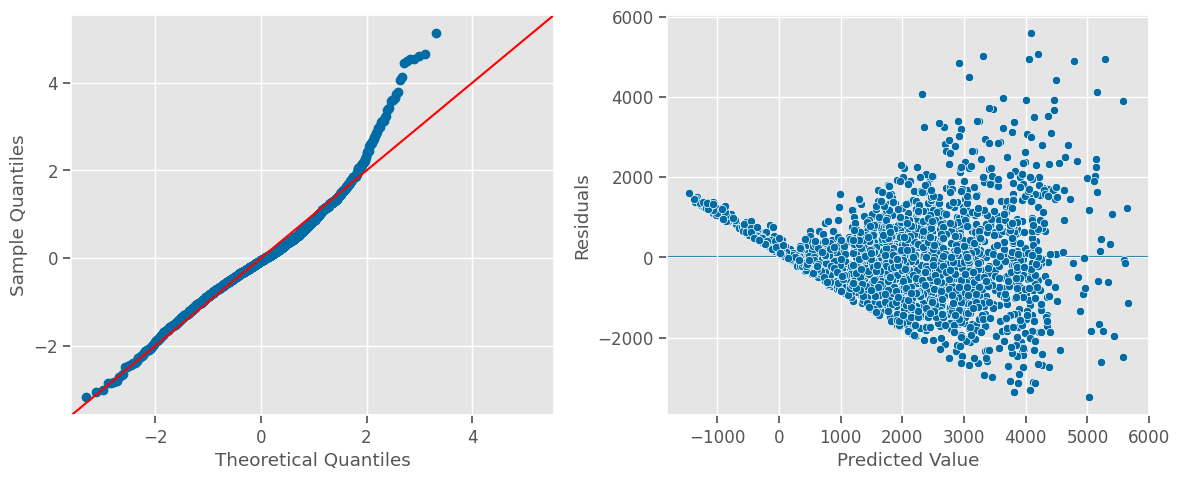

In [43]:
de.plot_residuals(lin_reg, X_test_df,y_test)

In [45]:
coeffs_noint = get_coefficients(lin_reg_noint)
coeffs_noint.sort_values()

Outlet_Type_Grocery Store         -856.151131
Outlet_Identifier_OUT010          -470.523422
Item_Visibility                   -423.390180
Outlet_Identifier_OUT019          -385.627709
Outlet_Size_MISSING               -295.259683
Outlet_Location_Type_Tier 1       -218.777952
Outlet_Type_Supermarket Type2     -177.333542
Outlet_Identifier_OUT018          -177.333542
Item_Type_Dairy                   -124.804406
Outlet_Identifier_OUT049          -106.237694
Outlet_Size_Small                  -99.164762
Item_Type_Soft Drinks              -57.955127
Item_Type_Breads                   -47.117710
Item_Type_Others                   -45.283118
Item_Type_Snack Foods              -40.401784
Item_Type_Meat                     -30.334279
Item_Fat_Content_Low Fat           -30.167428
Item_Type_Frozen Foods             -20.240018
Item_Type_Baking Goods             -18.469392
Item_Type_Household                -12.959646
Item_Type_Hard Drinks               -4.574493
Item_Weight                       

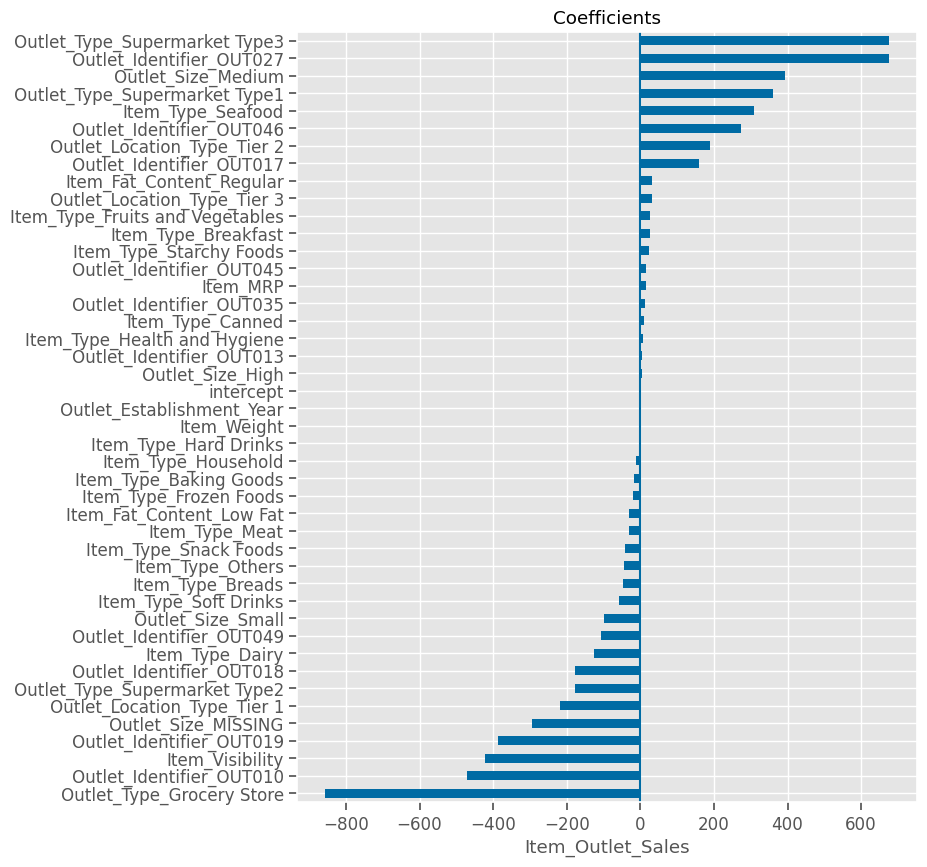

In [48]:
ax = coeffs_noint.sort_values().plot(kind='barh', figsize=(8,10))
ax.axvline(0)
ax.set(xlabel='Item_Outlet_Sales', title="Coefficients");